# MUT19 TOTW Analysis
### Jan 4, 2019
- Scraping using BeautifulSoup and requests
- Looking at the number of elite and gold TOTW Players compared with the respective team records

TODO:
- filter by offense/defense
- add some annotations to plots for clarity

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
import seaborn as sns
import urllib
import pandas as pd
import requests
import warnings; warnings.simplefilter('ignore')  
import time
import re
import os

### Helper Functions

In [2]:
# 
def get_player(player_raw):
    try:
        player_team = str(player_raw.find('span', class_='team-logo')).split(' ')[2].split('"')[0]
    except:
        player_team = '-'
    try:
        player_name = player_raw.find('a').contents[0].strip('\n').lstrip().split('\n')[0]
        #print(player_name)
    except:
        player_name = '-'
    try:
        price_link = str(player_raw.find('a', class_='player-price tip')).split('"')[3]
    except:
        price_link = '-'
    try:
        ovr = player_raw.find('td', class_='col-overall').contents[0]
    except: 
        ovr = '-'
    try:
        pos = player_raw.find('td', class_='col-position').contents[0]
    except:
        pos = '-'
    
    return {'name': player_name,
            'team': player_team,
            'ovr': ovr,
            'pos': pos,
            'price_link': price_link}

# 
def list_to_df(players):
    df = pd.DataFrame(players)
    df = df[ df['name']!='-']
    df['team'] = df['team'].str.upper()
    df['ovr'] = df['ovr'].astype(int)
    return df

# 
def get_players(tier, start=1, n_pages=1):
    players = []
    
    for i in range(start, n_pages + 1):
        try:
            tier_num = {'e': 16, 'g': 8}
            prefix = 'https://www.muthead.com/19'
            suffix = f'players?filter-market=3&filter-program-19=243&filter-tier={tier_num[tier.lower()]}&page={i}'
            url = os.path.join(prefix, suffix)
        
            #print('url', url)
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'lxml')
            table = soup.find('table')
            for j in range(1, len(table.find('tbody').contents)):
                time.sleep(2)
                player_raw = table.find('tbody').contents[j]
                players.append(get_player(player_raw))
        except ConnectionError:
            print('connection error', url, 'i:', i)
            return list_to_df(players)
    return list_to_df(players)

In [36]:
#def set_palette(self):
team_palette = {'PHI': 'xkcd:green', 'NE': 'darkblue', 'NO': 'gold', 'GB': 'green', 'MIN': 'xkcd:purple',
                     'WAS': 'maroon', 'TEN': 'cyan', 'TB': 'xkcd:crimson', 'SEA': 'chartreuse',
                     'LAC': 'xkcd:azure', 'ATL': 'xkcd:red', 'BAL': 'indigo', 'LA': 'xkcd:khaki',
                     'KC': 'red', 'NYJ': 'darkgreen', 'JAX': 'xkcd:darkgreen', 'OAK': 'grey',
                     'BUF': 'xkcd:blue', 'CAR': 'aqua', 'CLE': 'chocolate', 'PIT': 'xkcd:yellow', 'NYG': 'blue',
                     'SF': 'xkcd:gold', 'CHI': 'xkcd:orange', 'DAL': 'xkcd:darkblue', 'MIA': 'xkcd:aqua',
                     'DEN': 'xkcd:orangered', 'HOU': 'xkcd:navy', 'ARI': 'xkcd:red', 'CIN': 'xkcd:orange',
                     'DET': 'xkcd:lightblue', 'IND': 'xkcd:azure'}

**Need: number of pages for each page:**
- elite: https://www.muthead.com/19/players?filter-market=3&filter-program-19=243&filter-tier=16&page=1
- gold: https://www.muthead.com/19/players?filter-market=3&filter-program-19=243&filter-tier=8&page=1

TODO:
- better way to do this without specifying pages

In [3]:
elite_pages = 8
gold_pages = 3
date = 'jan4'

### Elite

In [ ]:
elitesA = get_players(tier='e', start=1, n_pages=5)
elitesA.to_csv(f'totw_elite_a_{date}.csv')

In [ ]:
elitesB = get_players(tier='e', start=6, n_pages=elite_pages)
elitesB.to_csv(f'totw_elite_b_{date}.csv')

In [6]:
elites = pd.concat([elitesA, elitesB])
elites.to_csv(f'totw_elite_{date}.csv')

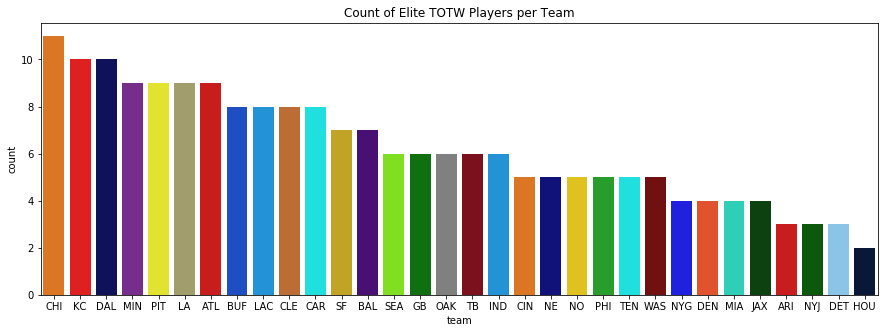

In [69]:
plt.figure(figsize=(15, 5))
sns.countplot(elites['team'], palette=team_palette, order = elites['team'].value_counts().index);
plt.title('Count of Elite TOTW Players per Team');

### Gold

In [8]:
#golds = get_players('g', n_pages=gold_pages)
#golds.to_csv(f'totw_gold_{date}.csv')

In [11]:
golds = pd.read_csv('totw_gold_jan2.csv')
df = pd.concat([elites, golds])

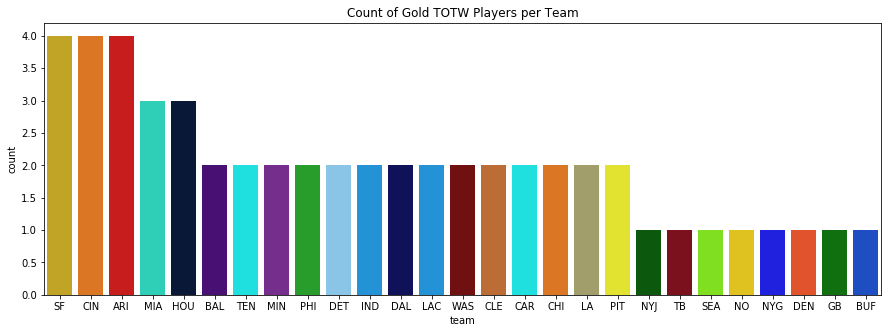

In [173]:
plt.figure(figsize=(15, 5))
sns.countplot(golds['team'], palette=team_palette, order = golds['team'].value_counts().index);
plt.title('Count of Gold TOTW Players per Team');

### All TOTW Players

In [159]:
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,name,ovr,pos,price_link,team,off_def
0,Justin Houston,96,LOLB,/19/players/prices/56271-justin-houston,KC,D
1,Michael Thomas,96,WR,/19/players/prices/56270-michael-thomas,NO,O
2,Amari Cooper,95,WR,/19/players/prices/56268-amari-cooper,DAL,O
3,Zach Ertz,95,TE,/19/players/prices/56265-zach-ertz,PHI,O
4,DeMarcus Lawrence,95,LE,/19/players/prices/56266-demarcus-lawrence,DAL,D


#### Offense vs Defense distribution for Teams

TODO: stacked bar plot

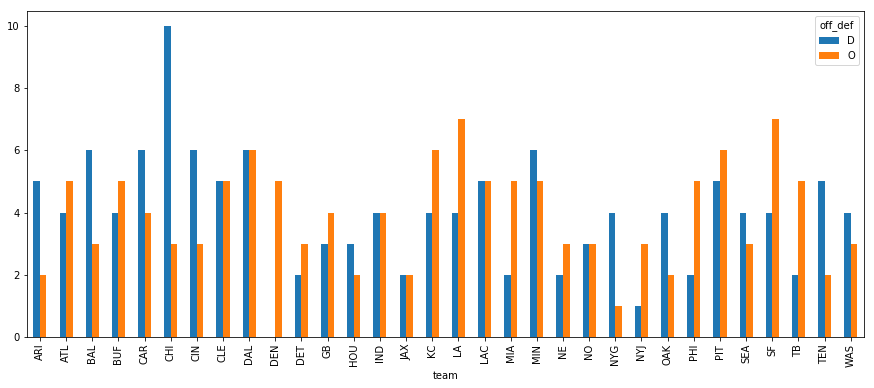

In [181]:
pd.pivot_table(index='team', values='ovr', columns='off_def', aggfunc='count',data=df).fillna(0)\
    .plot(kind='bar',figsize=(15,6));

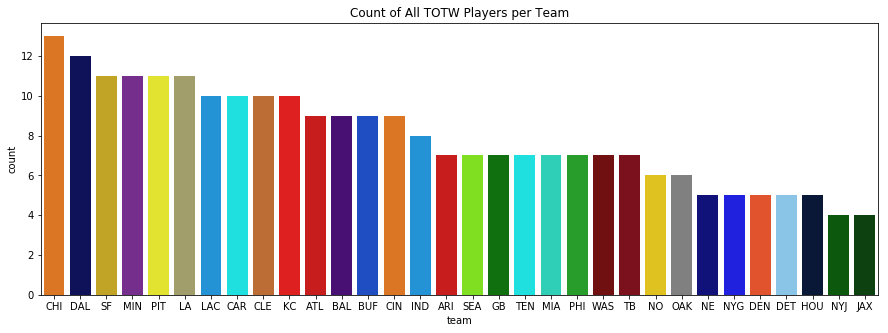

In [67]:
plt.figure(figsize=(15, 5))
sns.countplot(df['team'], palette=team_palette, order = df['team'].value_counts().index);
plt.title('Count of All TOTW Players per Team');

## NFL Standings

In [13]:
afc_path = '/Users/mattjohnson/PycharmProjects/MUT19/afc_standings.csv'
nfc_path = '/Users/mattjohnson/PycharmProjects/MUT19/nfc_standings.csv'
afc = pd.read_csv(afc_path)
nfc = pd.read_csv(nfc_path)
standings = pd.concat([afc, nfc])

In [150]:
# position dict to map to off/def
pos_dict = {'LOLB':'D', 'WR':'O', 'TE':'O', 'LE':'D', 'MLB':'D', 'ROLB':'D', 'HB':'O', 'SS':'D', 
            'QB':'O', 'CB':'D', 'DT':'D', 'FS':'D', 'RE':'D'}

# mapping positions
df['off_def'] = df['pos'].map(pos_dict)

In [156]:
df.head()

,Unnamed: 0,name,ovr,pos,price_link,team,off_def
0,NaN,Justin Houston,96,LOLB,/19/players/prices/56271-justin-houston,KC,D
1,NaN,Michael Thomas,96,WR,/19/players/prices/56270-michael-thomas,NO,O
2,NaN,Amari Cooper,95,WR,/19/players/prices/56268-amari-cooper,DAL,O
3,NaN,Zach Ertz,95,TE,/19/players/prices/56265-zach-ertz,PHI,O
4,NaN,DeMarcus Lawrence,95,LE,/19/players/prices/56266-demarcus-lawrence,DAL,D


In [149]:
#standings.sort_values('W', ascending=False)
teams = pd.read_csv('nfl_teams.csv')
teams.set_index('Name', drop=True, inplace=True)
team_dict = teams['Abbreviation'].to_dict()

standings['abbrev'] = standings['Tm'].map(team_dict)

# dict for tidy df team counts
team_count_dict = df['team'].value_counts().to_dict()
offdef_dict = df['off_def'].
# mapping by abbrev
standings['count'] = standings['abbrev'].map(team_count_dict)

# new df with wanted variables
all_df = standings[['Tm', 'W', 'PF', 'PA', 'PD', 'abbrev', 'count']]
all_df.sort_values('W', ascending=False, inplace=True)

In [185]:
def tidy(df):
    try:
        df = df[['abbrev', 'W', 'count']]
    except:
        print('must have columns: abbrev, W, count')
        print('your columns:', df.columns)
        return []
    if len(df.columns) != 3:
        print('x')
    try:
        tidy = (
        df.set_index('abbrev')
          .stack()  # un-pivots the data 
          .reset_index()  # moves all data out of the index
          .rename(columns={'level_1': 'Variable', 0: 'Value'})
        )
    except:
        print('error')
        return []
    return tidy

In [186]:
tidied = tidy(all_df)

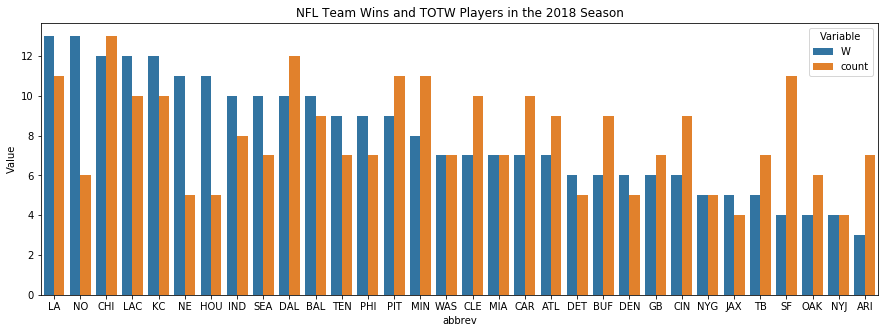

In [47]:
plt.figure(figsize=(15, 5))
sns.barplot(data=tidied, x='abbrev', y='Value', hue='Variable');
plt.title('NFL Team Wins and TOTW Players in the 2018 Season');

### Correlation

W: Wins, PF: Points For, PA: Points Against, PD: Net Points, count: number of TOTW players in season

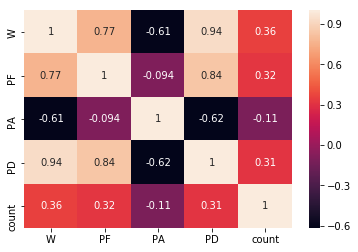

In [33]:
sns.heatmap(all_df.corr(), annot=True);

In [ ]:
sns.heatmap(all_df[ all_.corr(), annot=True);

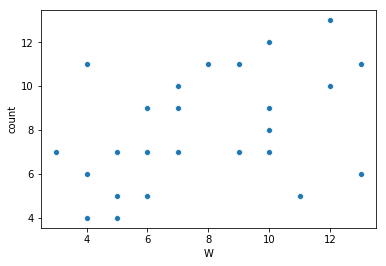

In [56]:
sns.scatterplot(data = all_df[['W', 'count']].reset_index(drop=True), x='W', y='count');

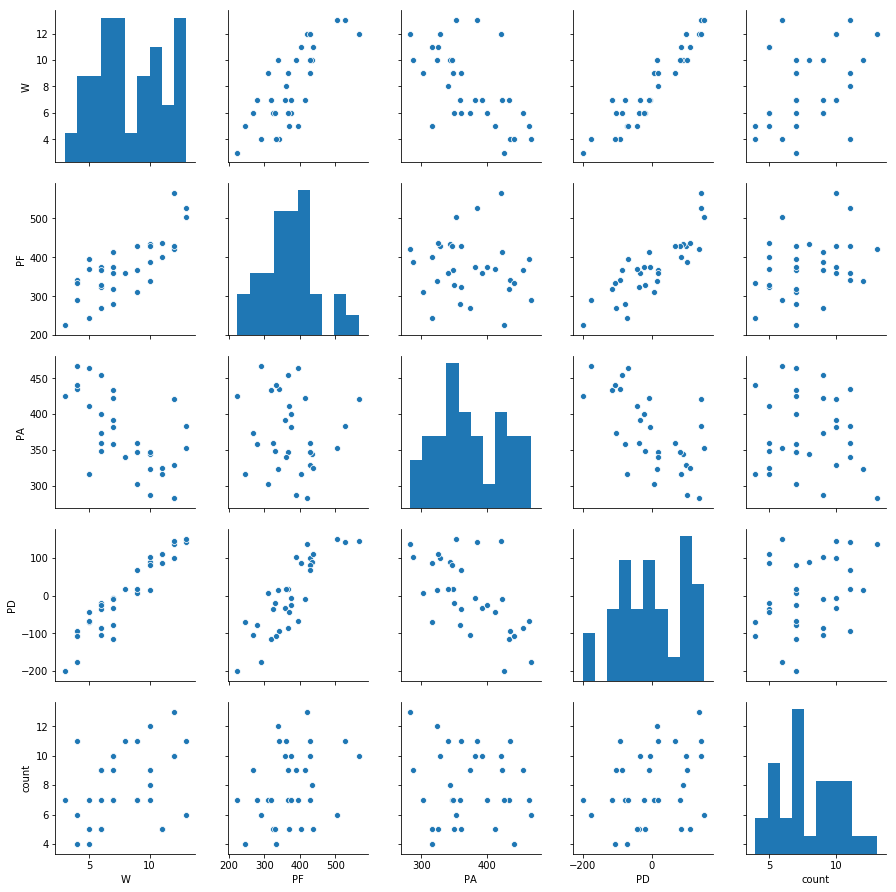

In [57]:
sns.pairplot(all_df)

### Trying with only elites:

In [61]:
teams = pd.read_csv('nfl_teams.csv')
teams.set_index('Name', drop=True, inplace=True)
team_dict = teams['Abbreviation'].to_dict()

standings['abbrev'] = standings['Tm'].map(team_dict)

# dict for tidy df team counts
team_count_dict = elites['team'].value_counts().to_dict()

# mapping by abbrev
standings['count'] = standings['abbrev'].map(team_count_dict)

# new df with wanted variables
elite_df = standings[['Tm', 'W', 'PF', 'PA', 'PD', 'abbrev', 'count']]
elite_df.sort_values('W', ascending=False, inplace=True)

In [63]:
tidy_elites = tidy(elite_df)

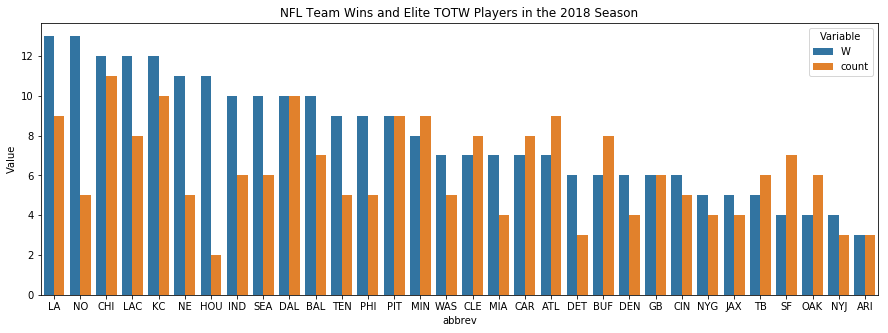

In [64]:
plt.figure(figsize=(15, 5))
sns.barplot(data=tidy_elites, x='abbrev', y='Value', hue='Variable');
plt.title('NFL Team Wins and Elite TOTW Players in the 2018 Season');

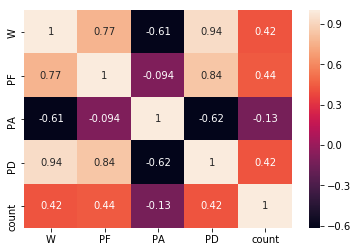

In [66]:
sns.heatmap(elite_df.corr(), annot=True);

In [74]:
elites.iloc[elites.groupby('team').groups['ARI']]

,name,ovr,pos,price_link,team
110,Eric Reid,85,SS,/19/players/prices/56118-eric-reid,CAR
35,Danielle Hunter,91,LE,/19/players/prices/56128-danielle-hunter,MIN
75,Josh Allen,86,QB,/19/players/prices/56215-josh-allen,BUF


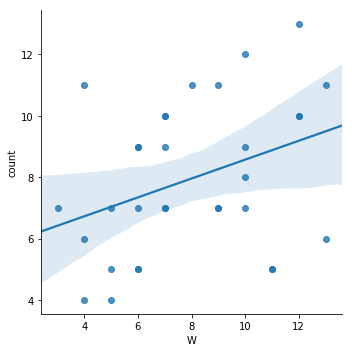

In [75]:
sns.lmplot(data = all_df[['W', 'count']].reset_index(drop=True), x='W', y='count');

In [84]:
elite_df['diff'] = elite_df['W'] - elite_df['count']

In [189]:
elite_df.sort_values('diff', ascending=False).reset_index(drop=True)

,Tm,W,PF,PA,PD,abbrev,count,diff
0,Houston Texans,11,402,316,86,HOU,2,9
1,New Orleans Saints,13,504,353,151,NO,5,8
2,New England Patriots,11,436,325,111,NE,5,6
3,Los Angeles Rams,13,527,384,143,LA,9,4
4,Tennessee Titans,9,310,303,7,TEN,5,4
5,Los Angeles Chargers,12,428,329,99,LAC,8,4
6,Indianapolis Colts,10,433,344,89,IND,6,4
7,Seattle Seahawks,10,428,347,81,SEA,6,4
8,Philadelphia Eagles,9,367,348,19,PHI,5,4
9,Miami Dolphins,7,319,433,-114,MIA,4,3


In [94]:
tidy_elites.head()

,abbrev,Variable,Value
0,LA,W,13
1,LA,count,9
2,NO,W,13
3,NO,count,5
4,CHI,W,12


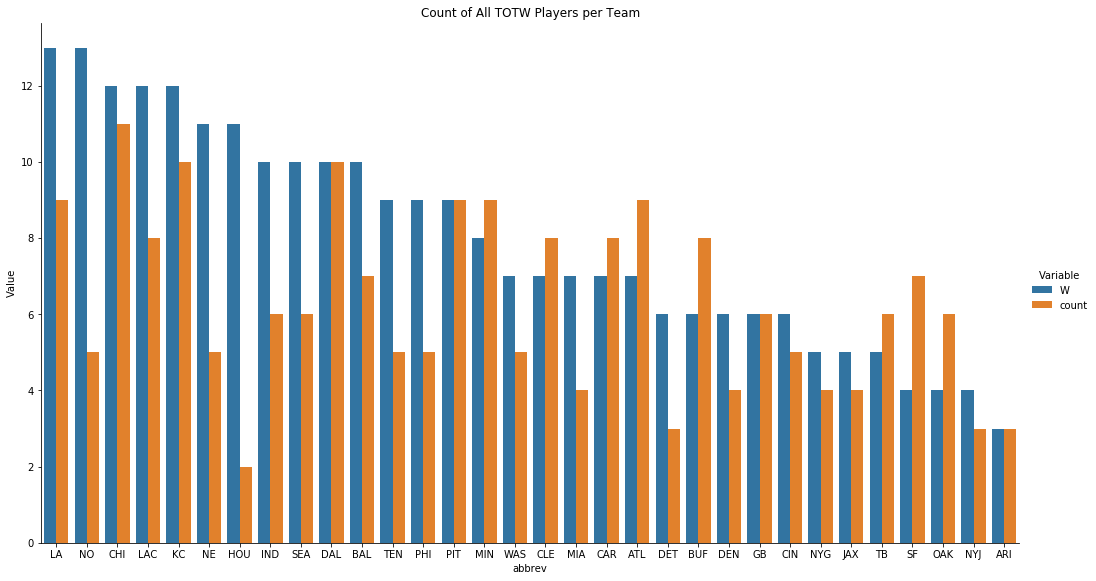

In [126]:
#plt.figure(figsize=(15, 8))
sns.catplot(x='abbrev', y='Value',hue='Variable', data = tidy_elites.set_index('abbrev', drop=False), 
            kind='bar', height=8, aspect=1.8); #palette=team_palette);
plt.title('Count of All TOTW Players per Team');